# KOH Example

## Kennedy and O’Hagan (KOH) 의 Bayesian Model Calibration

KOH framework는 실제 측정된 데이터의 값 z를 다음과 같이 모델링합니다.

$$
z = \rho \ \eta(x, t) + \delta(x) + e
$$

* $\eta(x, t)$ 는 컴퓨터 시뮬레이션 코드의 함수이며 $x$는 함수의 인자, $t$는 함수의 파라미터로 해석할 수 있습니다.  
* $\delta(x)$는 컴퓨터 시뮬레이터와 실제 물리 프로세스 사이의 차이를 나타냅니다.
* $e$는 관측 에러로 시뮬레이터 에러와 관측 에러를 모두 포함합니다.

$\eta(x, t)$와 $\delta(x)$는 Gaussian Process의 형태로 가정됩니다.

컴퓨터 시뮬레이션 코드의 데이터는 미리 지정된 $(y_i, x_i, t_i)$로 주어지며 관측된 물리 프로세스의 데이터는 $(z_i, x_i, \theta)$ 로 주어집니다.   
여기서 $y_i$는 시뮬레이션 코드의 아웃풋을 나타내며 관측된 $\theta$는 물리 프로세스에 가장 적합한 모델 파라미터값 입니다.  
$\theta$값은 알 수 없기 때문에 이 역시 MCMC 샘플링의 대상입니다.

2개의 observed data가 설정되며 각각 다음과 같습니다
$$

\begin{align}
y_i &\sim N(f_{c,i}, \sigma_c^2) \\
f_{c,i} &\sim \text{GP for } \eta
\end{align}
$$

$$
\begin{align}
z_i &\sim N(f_{p,i}, \sigma^2) \\
f_{p,i} &\sim \text{GP for } \eta + \text{GP for } \delta
\end{align}
$$

모든 관측 에러는 노말 분포로 가정되었으며 따라서 전체 관측에러인 컴퓨터 에러, 실험 관측에러의 합은 여전히 노말 분포로 표현할 수 있습니다.

## 1. 라이브러리 임포트

In [68]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

## 2. 데이터 임포트

In [69]:
# c stands for computed, p stands for field (physical process).
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")
df_f = pd.read_csv("../dataset/datafield_hourly.csv")

In [70]:
df_c

,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [71]:
df_f

,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 

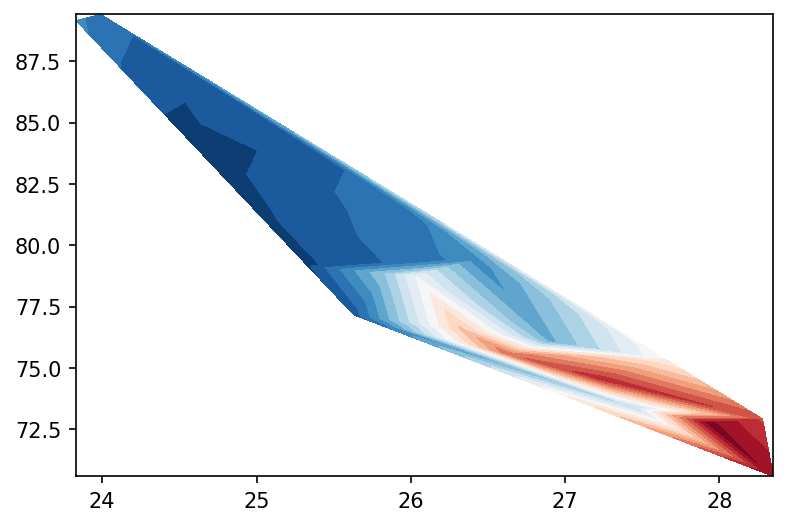

In [72]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.tricontourf(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    df_f.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)
plt.show()

# 4. KOH 모델 정의

### 4-1. 모델 정의를 위한 데이터 변수명 설정

In [73]:
df_c.describe()

,yc,xc1,xc2,tc1,tc2,tc3
count,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000
mean,238.212208,25.98625,79.417500,8.001000,6.422000,2.916000
std,153.872389,1.33510,5.316637,0.919768,0.734154,0.337964
min,81.710000,23.82000,70.580000,6.630000,5.370000,2.430000
25%,111.735000,24.95500,75.517500,7.100000,5.720000,2.610000
50%,161.390000,25.88000,78.790000,8.015000,6.360000,2.905000
75%,355.855000,26.98750,83.482500,8.670000,7.170000,3.240000
max,590.090000,28.35000,89.420000,9.340000,7.650000,3.450000


In [74]:
df_f.describe()

,yf,xf1,xf2
count,24.000000,24.000000,24.00000
mean,237.079167,25.990000,79.41750
std,154.280131,1.359767,5.41966
min,90.930000,23.830000,70.58000
25%,108.802500,24.955000,75.51750
50%,160.140000,25.885000,78.79000
75%,339.160000,26.987500,83.48250
max,533.400000,28.350000,89.42000


In [ ]:
# Normalize the data.

# Data from computed process
y = df_c.iloc[:, 0].values
y_min = y.min()
y_max = y.max()
y = (y - y_min) / (y_max - y_min)

x_c = df_c.iloc[:, 1:3].values
x_c_min = x_c.min(axis=0)
x_c_max = x_c.max(axis=0)
x_c = (x_c - x_c_min) / (x_c_max - x_c_min)

t_c = df_c.iloc[:, 3:].values
t_c_min = 0
t_c_max = t_c.max(axis=0)
t_c = (t_c - t_c_min) / (t_c_max - t_c_min)

print(y.shape, x_c.shape, t_c.shape)

# Data from physical process
z = df_f.iloc[:, 0].values
z = (z - y_min) / (y_max - y_min)
x_p = df_f.iloc[:, 1:3].values
x_p = (x_p - x_c_min) / (x_c_max - x_c_min)

print(z.shape, x_p.shape)

(240,) (240, 2) (240, 3)
(24,) (24, 2)


### 4-2. PyMC 모델 정의

In [85]:
theta_max = np.array([10, 10, 5]) / t_c_max
theta_max

array([1.07066381, 1.30718954, 1.44927536])

In [81]:
with pm.Model() as koh_model:
    # 1. 컴퓨터 모델 에뮬레이터 GP (eta).
    # 5차원 인풋 사용 (x1, x2, t1, t2, t3).
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=5)
    eta_eta = pm.HalfCauchy("eta_eta", beta=1)
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls_eta)
    gp_eta = pm.gp.Latent(cov_func=cov_eta)

    # 2. 모델 불일치 함수 GP (delta).
    # 2차원 인풋 사용 (x1, x2).
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5, shape=2)
    eta_delta = pm.HalfCauchy("eta_delta", beta=1)
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_delta)
    gp_delta = pm.gp.Latent(cov_func=cov_delta)

    # 3. 컴퓨터 모델 가능도 및 관측 정의.
    X_c = np.hstack([x_c, t_c])
    f_c_eta = gp_eta.prior("f_c_eta", X=X_c)

    # 컴퓨터 계산 노이즈 정의.
    sigma_c = pm.HalfNormal("sigma_c", sigma=0.01)

    # 관측 데이터 정의.
    y_obs = pm.Normal("y_obs", mu=f_c_eta, sigma=sigma_c, observed=y)

    # 4. 물리 모델 가능도 및 관측 정의.

    # theta prior 정의 (양수 값만 가능). t1, t2, t3의 3차원.
    theta = pm.Uniform("theta", lower=0, upper=theta_max, shape=3)

    X_p = pt.concatenate([x_p, pt.tile(theta, (x_p.shape[0], 1))], axis=1)
    f_p_eta = gp_eta.prior("f_p_eta", X=X_p)
    f_p_delta = gp_delta.prior("f_p_delta", X=x_p)

    f_p = pm.Deterministic("f_p", f_p_eta + f_p_delta)

    # 물리 계산 노이즈 정의.
    sigma = pm.HalfNormal("sigma", sigma=0.02)

    # 관측 데이터 정의.
    z_obs = pm.Normal("z_obs", mu=f_p, sigma=sigma, observed=z)

In [84]:
theta.eval()

array([0.52477364, 0.41909926, 1.41230537])

# 5. Sampling 수행

In [86]:
with koh_model:
    trace = pm.sample(
        draws=1000, tune=1000, chains=1, cores=1,
        nuts_sampler="numpyro",
        target_accept=0.95,
        # rogressbar=False,                     # 여기
        # nuts_sampler_kwargs={"progress_bar": False}, 
    )

sample: 100%|██████████| 2000/2000 [1:34:56<00:00,  2.85s/it, 1023 steps of size 9.67e-05. acc. prob=0.98]
Only one chain was sampled, this makes it impossible to run some convergence checks


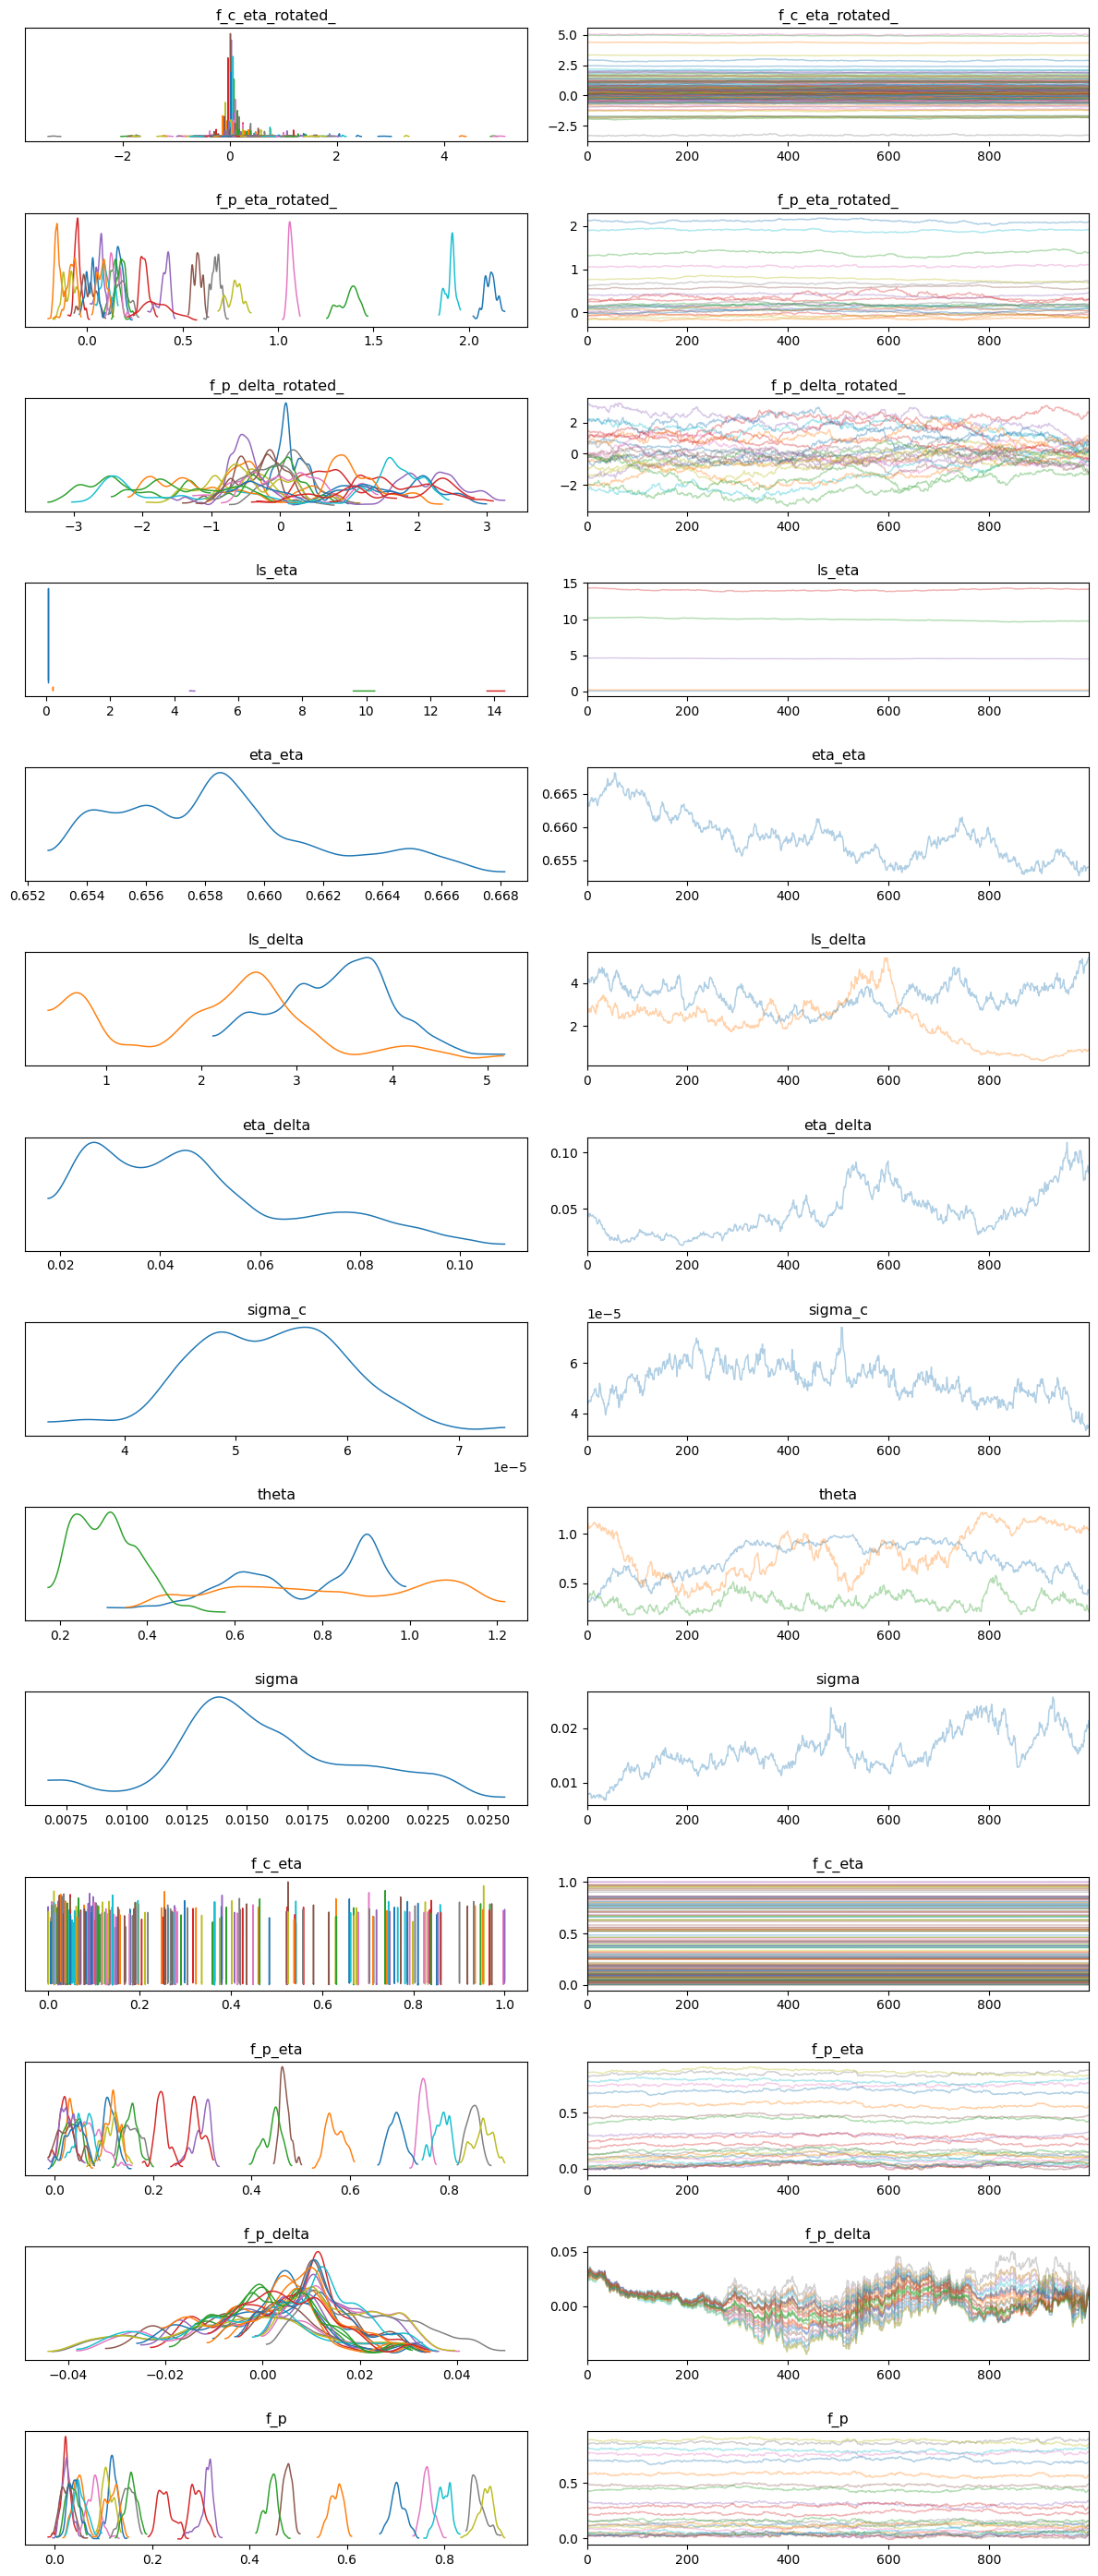

In [90]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

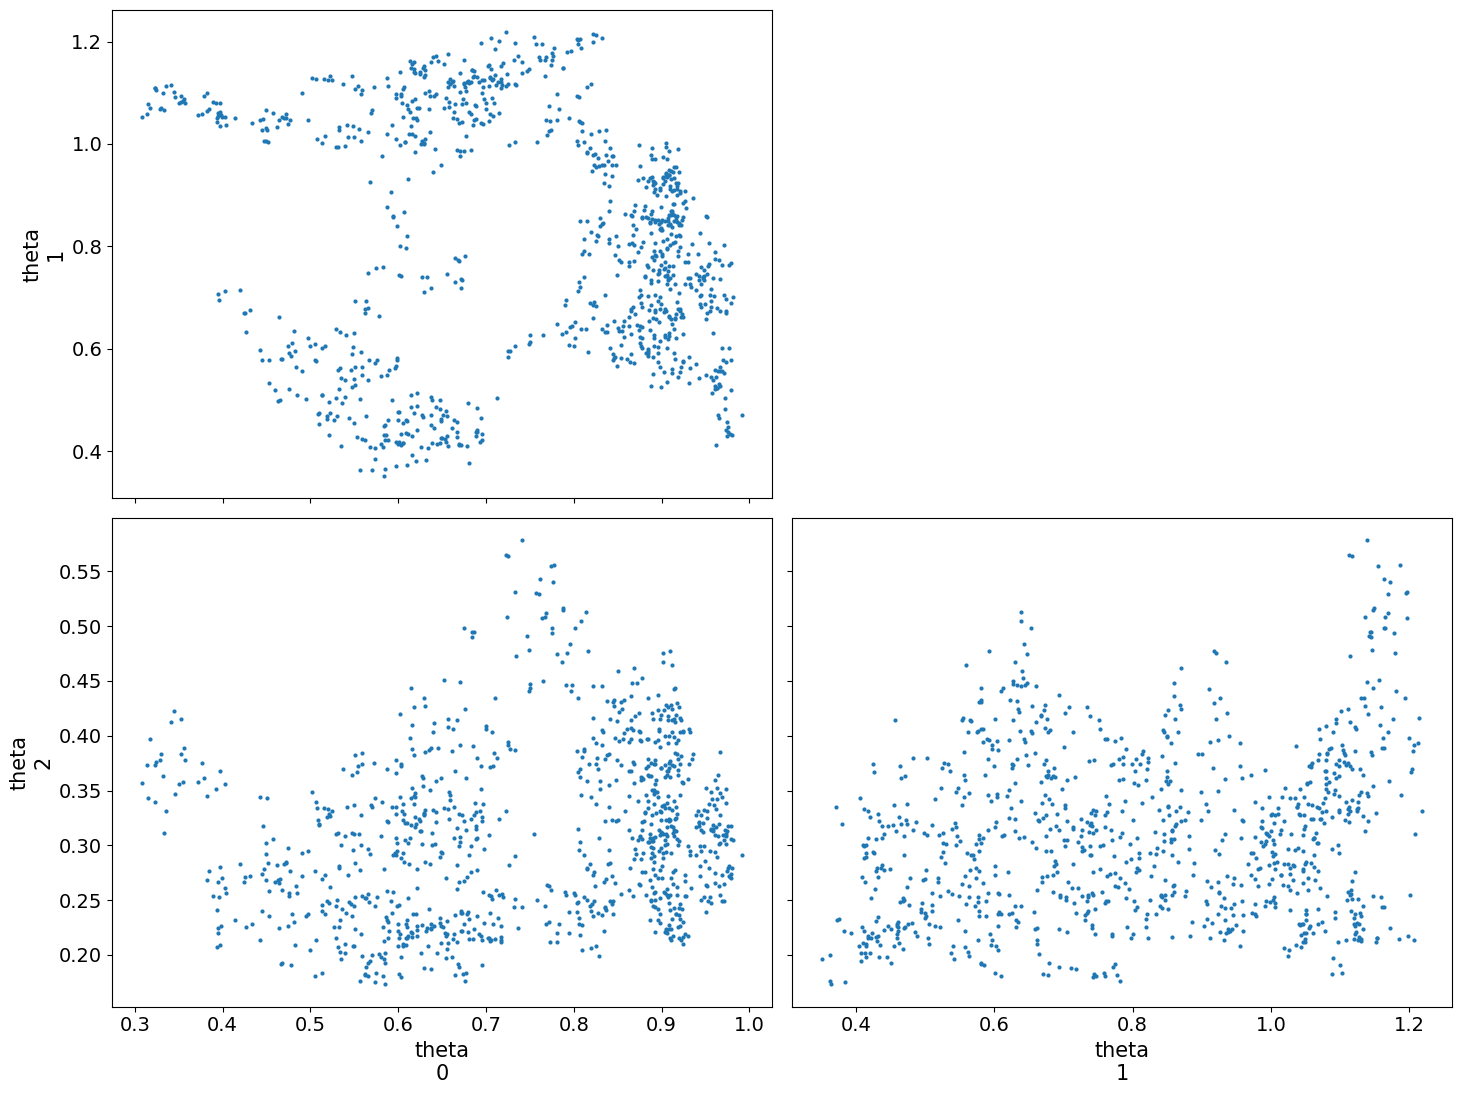

In [88]:
az.plot_pair(trace, var_names=["theta"])
plt.tight_layout()
plt.show()

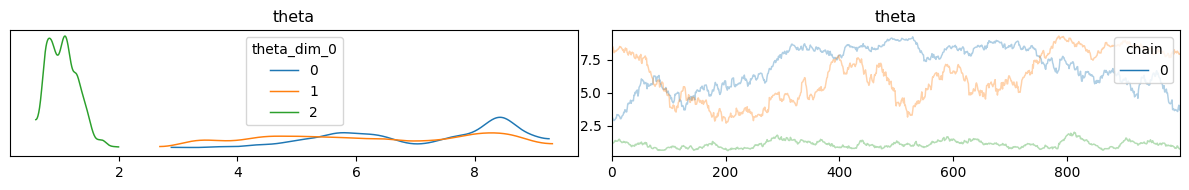

In [91]:
# theta 파라미터를 원래 물리적 단위로 역변환
# 정규화된 [0, 1] 범위에서 원래 파라미터 범위로 복원
trace_ = trace.copy()
trace_.posterior.theta.values *= t_c_max[None, None, :]  # 브로드캐스팅으로 모든 샘플에 적용

# 역변환된 theta 값들의 사후 분포 시각화
# 이제 물리적 단위로 해석 가능 (기기밀도, 조명밀도, COP)
az.plot_trace(trace_, legend=True, var_names=["theta"])
plt.tight_layout()
plt.show()

In [54]:
with koh_model:
    samples = pm.sample_posterior_predictive(
        trace,
        var_names=["y_obs", "z_obs"],
    )

Sampling: [y_obs, z_obs]


Output()

In [55]:
samples.posterior_predictive.y_obs.mean(axis=(0, 1))

<xarray.DataArray 'y_obs' (y_obs_dim_0: 240)> Size: 2kB
array([ 9.22883831e-02,  2.83450973e-02,  6.85165312e-03,  6.84250515e-03,
       -1.39012171e-06,  1.00995789e-02,  5.96903841e-02,  1.32004939e-01,
        8.73460279e-02,  2.54589828e-02,  2.27676470e-02,  7.90608688e-02,
        1.18603306e-01,  1.79052689e-01,  2.77076594e-01,  4.34920094e-01,
        7.02679067e-01,  8.03759284e-01,  8.26085698e-01,  7.45562170e-01,
        6.59853160e-01,  5.42865189e-01,  3.90421059e-01,  2.52391310e-01,
        9.83211373e-02,  2.85990996e-02,  7.56512156e-03,  7.57680232e-03,
        5.07050305e-04,  1.12813994e-02,  5.91681834e-02,  1.26264771e-01,
        8.27123862e-02,  2.38659870e-02,  2.18927004e-02,  9.15897219e-02,
        1.44035143e-01,  2.18729035e-01,  3.36418691e-01,  5.23517663e-01,
        8.37089474e-01,  9.35244868e-01,  9.47399424e-01,  8.35907016e-01,
        7.19101780e-01,  5.81230480e-01,  4.14420029e-01,  2.67941760e-01,
        1.11316088e-01,  5.25666041e-02,  2.77135903e-02,  2.77245690e-02,
        1.91441526e-02,  3.34769192e-02,  8.17438765e-02,  1.41034564e-01,
        9.55386489e-02,  3.88698451e-02,  4.59922365e-02,  1.09370486e-01,
        1.40273114e-01,  1.97346803e-01,  2.90885607e-01,  4.25887476e-01,
        6.78777638e-01,  7.72144842e-01,  7.91829325e-01,  7.12902567e-01,
        6.29761934e-01,  5.21628041e-01,  3.79339486e-01,  2.54708612e-01,
        1.12471350e-01,  4.85734698e-02,  2.22695628e-02,  2.22676423e-02,
        1.45194082e-02,  2.63335423e-02,  7.90589784e-02,  1.53121626e-01,
...
        8.51257621e-01,  9.52773432e-01,  9.67749834e-01,  8.60360621e-01,
        7.48268172e-01,  6.15198262e-01,  4.48738182e-01,  3.05420854e-01,
        1.37923789e-01,  6.12766768e-02,  2.81409934e-02,  2.81584891e-02,
        2.01980476e-02,  3.21208118e-02,  8.76864707e-02,  1.67058306e-01,
        1.16784323e-01,  4.79786112e-02,  6.14084903e-02,  1.40913172e-01,
        1.79168961e-01,  2.48218387e-01,  3.60169219e-01,  5.40523980e-01,
        8.53952021e-01,  9.71812245e-01,  9.96924587e-01,  9.00971064e-01,
        7.99270486e-01,  6.62420807e-01,  4.84392821e-01,  3.24041648e-01,
        1.08354635e-01,  4.88149703e-02,  2.45606156e-02,  2.45626755e-02,
        1.62770359e-02,  2.98159336e-02,  7.87792130e-02,  1.41344140e-01,
        9.56836522e-02,  3.74202996e-02,  4.25267687e-02,  1.03839187e-01,
        1.34697852e-01,  1.90822578e-01,  2.83061163e-01,  4.19113189e-01,
        6.70036183e-01,  7.65642064e-01,  7.87199706e-01,  7.11615808e-01,
        6.31601873e-01,  5.24000739e-01,  3.80977030e-01,  2.54363240e-01,
        1.78524511e-01,  1.04450088e-01,  5.87392854e-02,  5.77520017e-02,
        4.79957307e-02,  6.35772745e-02,  1.24298705e-01,  2.04861581e-01,
        1.48771230e-01,  7.95268980e-02,  1.26475942e-01,  1.84724505e-01,
        2.12434706e-01,  2.74777005e-01,  3.79320972e-01,  5.38832646e-01,
        8.39447411e-01,  9.66526416e-01,  9.99995115e-01,  9.18703257e-01,
        8.31899815e-01,  7.03331173e-01,  5.25186606e-01,  3.64441746e-01])
Coordinates:
  * y_obs_dim_0  (y_obs_dim_0) int64 2kB 0 1 2 3 4 5 ... 234 235 236 237 238 239

In [56]:
y

array([9.22734962e-02, 2.83646092e-02, 6.84527322e-03, 6.84527322e-03,
       0.00000000e+00, 1.00712066e-02, 5.96994374e-02, 1.32007553e-01,
       8.73559149e-02, 2.54730713e-02, 2.27585664e-02, 7.90550376e-02,
       1.18592392e-01, 1.79058972e-01, 2.77076203e-01, 4.34910893e-01,
       7.02663362e-01, 8.03768834e-01, 8.26094654e-01, 7.45564342e-01,
       6.59860734e-01, 5.42861639e-01, 3.90416617e-01, 2.52389945e-01,
       9.83319564e-02, 2.86006531e-02, 7.57307526e-03, 7.57307526e-03,
       5.11428459e-04, 1.12907667e-02, 5.91683386e-02, 1.26263818e-01,
       8.27137181e-02, 2.38601046e-02, 2.18930721e-02, 9.15850348e-02,
       1.44026122e-01, 2.18734018e-01, 3.36421574e-01, 5.23506039e-01,
       8.37090365e-01, 9.35245289e-01, 9.47401550e-01, 8.35910146e-01,
       7.19107754e-01, 5.81238444e-01, 4.14414414e-01, 2.67949172e-01,
       1.11314371e-01, 5.25591093e-02, 2.77154884e-02, 2.77154884e-02,
       1.91392266e-02, 3.34788937e-02, 8.17498721e-02, 1.41036233e-01,
      

In [57]:
samples.posterior_predictive.z_obs.mean(axis=(0, 1))

<xarray.DataArray 'z_obs' (z_obs_dim_0: 24)> Size: 192B
array([ 0.15578894,  0.0211437 ,  0.05860353,  0.03053299,  0.00570405,
        0.06128406,  0.07984264,  0.09503345,  0.1569865 , -0.00533688,
        0.06028073,  0.21373364,  0.21940284,  0.20848772,  0.31735964,
        0.51737645,  0.73473756,  0.89296974,  0.85952605,  0.74755035,
        0.6244609 ,  0.61475801,  0.37963046,  0.2627047 ])
Coordinates:
  * z_obs_dim_0  (z_obs_dim_0) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

In [58]:
z

array([0.12177898, 0.05434911, 0.02629922, 0.02629922, 0.01813604,
       0.03105944, 0.08273339, 0.15207129, 0.10448877, 0.04193713,
       0.05011999, 0.12148393, 0.15647744, 0.21952083, 0.32204257,
       0.47964121, 0.76167434, 0.86643849, 0.88848893, 0.80113301,
       0.7088005 , 0.58672646, 0.4274165 , 0.28567214])